# Web data: Amazon reviews

Opis danych ze strony http://snap.stanford.edu/data/web-Amazon-links.html
- product/productId: asin, e.g. amazon.com/dp/B00006HAXW
- product/title: title of the product
- product/price: price of the product
- review/userId: id of the user, e.g. A1RSDE90N6RSZF
- review/profileName: name of the user
- review/helpfulness: fraction of users who found the review helpful
- review/score: rating of the product
- review/time: time of the review (unix time)
- review/summary: review summary
- review/text: text of the review 

# Import potrzebnych modułów

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import simplejson
from datetime import datetime, date
from itertools import combinations
from collections import Counter
pd.set_option("display.precision", 4)
plt.style.use('ggplot')
%matplotlib inline

# Załadowanie danych do Pandas DataFrame

In [2]:
def parse(filename):
    f = gzip.open(filename, 'rt')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


df = getDF('Cell_Phones_&_Accessories.txt.gz')
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


# Preprocessing danych

Zmiana typów danych

In [3]:
df["review/score"] = df["review/score"].astype("float64")

print("Rozmiar zbioru danych: " + str(df.shape))

Rozmiar zbioru danych: (78930, 10)


Wypisanie oraz usunięcie zduplikowanych rekordów

In [4]:
duplicated_rows_df = df[df.duplicated()]
print("Liczba zduplikowanych rekordów: " + str(duplicated_rows_df.shape[0]))
print("Zduplikowane rekordy: ")
duplicated_rows_df.head(3)

Liczba zduplikowanych rekordów: 36
Zduplikowane rekordy: 


,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
90,B00004WINT,Jabra EarGels - Clear,9.70,A37XJZF145XH5B,A. Trujillo,4/4,5.0,1214265600,Comfort at last,"I bought these eargels for my bluetooth, which..."
5248,B00074V0JY,Motorola Lithium-Ion Battery BR50 / SNN5696 / ...,4.51,A2JKD82K7NWK1U,"R. Badger ""Knower of All, Master of None""",3/3,5.0,1154822400,GREAT battery,Oredered this battery thinking it was the olde...
6108,B00006I9SY,Plantronics M1500 Bluetooth Headset With Adapt...,unknown,unknown,unknown,2/6,1.0,1051660800,Uncomfortable earpiece..,The product works fine but the earpiece is way...


In [5]:
df.drop_duplicates(keep="first", inplace=True)
print("Rozmiar zbioru po usunięciu duplikatów: " + str(df.shape))

Rozmiar zbioru po usunięciu duplikatów: (78894, 10)


Utworzenie dodatkowych kolumn

In [6]:
# Dodanie kolumny zawierającej długość tekstu
df['text_length'] = df['review/text'].apply(len)

# Kolumna zawierająca wartości 0 i 1. Jeżeli opinia była negatywna, miała opinię mniejszą lub równą 3, przypisywana
#                                                                            jest wartość 0, 1 w reszcie przypadków)
df['score_bool'] = df['review/score'].apply(lambda row: 0 if row <= 3.0 else 1)

# Kolumna zamieniająca format daty
df['date'] = pd.to_datetime(df['review/time'], unit='s')

# Kolumny zawierające rok, miesiąc, dzień oraz dzień tygodnia - pomocne przy późniejszych analizach
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

# Kolumny zawierające przydatność opinii
df['good_helpfulness'] = df['review/helpfulness'].apply(lambda row: row.split('/')[0]) # Ilość osób, która uważa opinię za użyteczną
df['all_helpfulness'] = df['review/helpfulness'].apply(lambda row: row.split('/')[1]) # Ilość osób, która oceniła opinię

df['good_helpfulness'] = df['good_helpfulness'].astype("int64")
df['all_helpfulness'] = df['all_helpfulness'].astype("int64")

Usunięcie niepotrzebnych kolumn oraz zamiana nazw istniejących

In [7]:
df.drop(['product/productId', 'review/profileName', 'review/helpfulness', 'review/time'], axis=1, inplace=True)

df.rename(columns={'product/title': 'title', 'product/price': 'price', 'review/userId': 'user_id',
           'review/score': 'score', 'review/summary': 'summary', 'review/text': 'text'}, inplace=True)

Przekształcenie tekstu

In [8]:
# Usunięcie spacji na początku i na końcu tytułu oraz zamiana na małe litery
df['title'] = df['title'].apply(lambda x: x.strip().lower())

# Późniejsza analiza wykazała, że ponad 500 rekordów nie posiada nazw produktu, takie rekordy się nie przydadzą
df = df[df['title'] != '']

Wygląd danych po przekształceniach

In [9]:
df.head()

,title,price,user_id,score,summary,text,text_length,score_bool,date,year,month,day,weekday,good_helpfulness,all_helpfulness
0,mobile action ma730 handset manager - bluetoot...,unknown,A1RXYH9ROBAKEZ,1.0,Don't buy!,"First of all, the company took my money and se...",716,0,2009-01-31,2009,1,31,5,0,0
1,mobile action ma730 handset manager - bluetoot...,unknown,A7L6E1KSJTAJ6,5.0,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,164,1,2007-10-04,2007,10,4,3,0,0
2,mobile action ma730 handset manager - bluetoot...,unknown,A2NOQQ7I6PU7CW,4.0,good,works real good....a little hard to set up...w...,146,1,2007-08-10,2007,8,10,4,0,0
3,"usb data cable for sony-ericsson z600, z500, z...",unknown,A29Q0CLOF0U8BN,4.0,No instructions included...,The price was right for this cable ($11.95+$4....,1340,1,2006-04-28,2006,4,28,4,4,5
4,"usb data cable for sony-ericsson z600, z500, z...",unknown,ANNHJND2MHUI3,1.0,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,66,0,2007-03-12,2007,3,12,0,0,0


# Podstawowa analiza danych

In [10]:
print("Nazwy kolumn:")
print([column for column in df.columns])

Nazwy kolumn:
['title', 'price', 'user_id', 'score', 'summary', 'text', 'text_length', 'score_bool', 'date', 'year', 'month', 'day', 'weekday', 'good_helpfulness', 'all_helpfulness']


Podstawowe informacje o zbiorze

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78347 entries, 0 to 78929
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             78347 non-null  object        
 1   price             78347 non-null  object        
 2   user_id           78347 non-null  object        
 3   score             78347 non-null  float64       
 4   summary           78347 non-null  object        
 5   text              78347 non-null  object        
 6   text_length       78347 non-null  int64         
 7   score_bool        78347 non-null  int64         
 8   date              78347 non-null  datetime64[ns]
 9   year              78347 non-null  int64         
 10  month             78347 non-null  int64         
 11  day               78347 non-null  int64         
 12  weekday           78347 non-null  int64         
 13  good_helpfulness  78347 non-null  int64         
 14  all_helpfulness   7834

W zbiorze jest 1 kolumna zawierająca datę (format datetime64), 1 zawierająca liczby zmiennoprzecinkowe (float64), 6 kolumn zawierające liczby całkowite (int64) oraz 7 zawierających obiekty - w szczególności tekst (object). Można zauważyć, że w zbiorze nie ma wartości null. Jednakże isnieją wartości unknown, należy się temu dokładniej przyjrzeć.

In [12]:
for column in df:
    if 'unknown' in set(df[column]):
        print(f"Wartość 'unknown' jest w kolumnie {column}")

Wartość 'unknown' jest w kolumnie price
Wartość 'unknown' jest w kolumnie user_id


Wartość unknown występuje tylko w 2 kolumnach.

Następnie zobaczmy statystyki dla kolumn:

In [13]:
df.describe(include=['object'])

,title,price,user_id,summary,text
count,78347,78347,78347,78347,78347
unique,7142,944,67715,59872,76851
top,plantronics voyager 510 bluetooth headset [ret...,unknown,unknown,Great Product,I had been very happy with my Motorola phone u...
freq,3443,42718,2145,211,20


In [14]:
df.describe(include=['float64', 'int64'])

,score,text_length,score_bool,year,month,day,weekday,good_helpfulness,all_helpfulness
count,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000
mean,3.5211,554.6420,0.6071,2007.5876,6.2257,15.5578,2.8553,3.0275,3.9351
std,1.5252,676.8945,0.4884,2.4223,3.6125,8.7511,1.9808,12.3190,13.3626
min,1.0000,6.0000,0.0000,1999.0000,1.0000,1.0000,0.0000,0.0000,0.0000
25%,2.0000,182.0000,0.0000,2006.0000,3.0000,8.0000,1.0000,0.0000,0.0000
50%,4.0000,344.0000,1.0000,2007.0000,6.0000,15.0000,3.0000,1.0000,1.0000
75%,5.0000,657.0000,1.0000,2009.0000,9.0000,23.0000,5.0000,3.0000,4.0000
max,5.0000,15622.0000,1.0000,2013.0000,12.0000,31.0000,6.0000,1222.0000,1243.0000


Najważniejsze informacje jakie można zaobserwować na podstawie tych statystyk:
- title - występuje 7142 różnych przedmiotów. Najczęściej opiniowanym przedmiotem jest zestaw słuchawkowy Plantronics Voyager 510, ma on 3443 opinii.
- price - 42718 opinii nie zawiera ceny przedmiotu. W ponad połowie zbioru nie ma tej wartości, nie wnosi ona użytecznych informacji. Można uzupełniać wartości różnymi metodami, np. wartością średnią lub medianą, ale w tym przypadku nie ma to sensu, należy usunąć całą kolumnę.
- user_id - istnieje 78347 opinii wystawionych przez 67715 różnych użytkowników. W tym użytkownicy, którzy z jakiegoś powodu nie mają numeru id (przyczyn może być wiele, np. błąd zapisu w trakcie tworzenia bazy danych) wystawili 2145 opinii. W zależności od dalszej analizy, można usunąć te wiersze, ponieważ stanowią one tylko 2,7 % całości zbioru
- summary - istnieje 59872 unikalnych streszczeń, co jest spowodowane popularnymi zwrotami, np. "Great Product", "Works great", "Excellent"
- text - istnieje 76851 unikalnych opinii. Aż 20 jest takich samych, co jest mało prawdopodobne. Należy się temu dokładniej przyjrzeć
- score - wartości score znajdują się w przedziale [1, 5] Co ciekawe, wartość 4 jest w 50 percentylu, oznacza to, że ponad połowa ocen ma wartość 4 lub 5.
- text_length - długość tekstu jest w granicach od 6 znaków, aż do 15622. Wartość średnia wynosi 554, za to odchylenie standardowe jest bardzo wysokie - 676. 75 % osób napisało opinie poniże 657 znaków. 25 % osób napisało bardzo długie opinie, sięgające aż 15622 znaków, co bardzo wpłynęło na odchylenie standardowe.
- score_bool - jest to wartość binarna, dlatego wartość minimalna, maksymalna oraz percentyle przyjęły tak równe wartości. Średnia wynosi 0.60, co potwierdza wnioski z kolumny score - większość opinii jest pozytywna, ma wartości 4 lub 5.
- year - opinie są z lat 1999 - 2013. Średnia wyniosła 2007,58, a odchylenie standardowe 2,42, co oznacza, że dane są nieznacznie "przesunięte w prawo" i skoncentrowane wokół średniej.
- month, day, weekday - z powyższych informacji wynika, że dane dla tych kolumn są w miarę równomiernie rozłożone
- good_helpfulness - dane bardzo nierównomiernie rozłożone, ponad połowa opinii nie ma, lub ma tylko 1 pozytywną ocenę pomocności. Duże odchylenie standardowe oraz bardzo wysoka wartość maksimum, może być spowodowana ocenianiem przez użytkowników opinii, które wyświetlają się jako pierwsze na stronie.
- all_helpfulness - wartości tej kolumny są bardzo związane z poprzednią, tylko dochodzą tutaj jeszcze negatywne oceny

In [15]:
# Usuń kolumnę price
df.drop(['price'], axis=1, inplace=True)

# Usuń wiersze bez user_id
df = df[df['user_id'] != 'unknown']

Przyjrzyjmy się dokładniej najczęstszej wartości z kolumny text

In [16]:
df[df['text'] == df['text'].value_counts().index[0]].head(3)

,title,user_id,score,summary,text,text_length,score_bool,date,year,month,day,weekday,good_helpfulness,all_helpfulness
10594,motorola i305 phone (nextel),AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,1,4
14280,motorola c155 silver prepaid net10 cell phone,AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,19,22
15079,motorola i530 yellow phone (nextel),AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,6,6


Widać tutaj, że pomimo dokładnie takiego samego tekstu opinii oraz daty, są to zupełnie różne opinie. Są one przypisane do innych przedmiotów oraz mają inne oceny pomocności.

In [17]:
df.head()

,title,user_id,score,summary,text,text_length,score_bool,date,year,month,day,weekday,good_helpfulness,all_helpfulness
0,mobile action ma730 handset manager - bluetoot...,A1RXYH9ROBAKEZ,1.0,Don't buy!,"First of all, the company took my money and se...",716,0,2009-01-31,2009,1,31,5,0,0
1,mobile action ma730 handset manager - bluetoot...,A7L6E1KSJTAJ6,5.0,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,164,1,2007-10-04,2007,10,4,3,0,0
2,mobile action ma730 handset manager - bluetoot...,A2NOQQ7I6PU7CW,4.0,good,works real good....a little hard to set up...w...,146,1,2007-08-10,2007,8,10,4,0,0
3,"usb data cable for sony-ericsson z600, z500, z...",A29Q0CLOF0U8BN,4.0,No instructions included...,The price was right for this cable ($11.95+$4....,1340,1,2006-04-28,2006,4,28,4,4,5
4,"usb data cable for sony-ericsson z600, z500, z...",ANNHJND2MHUI3,1.0,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,66,0,2007-03-12,2007,3,12,0,0,0


# Przedstawienie danych na wykresach
Funkcja pomocnicza do ustawiania właściwości wykresu

In [33]:
def set_plot_properties(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

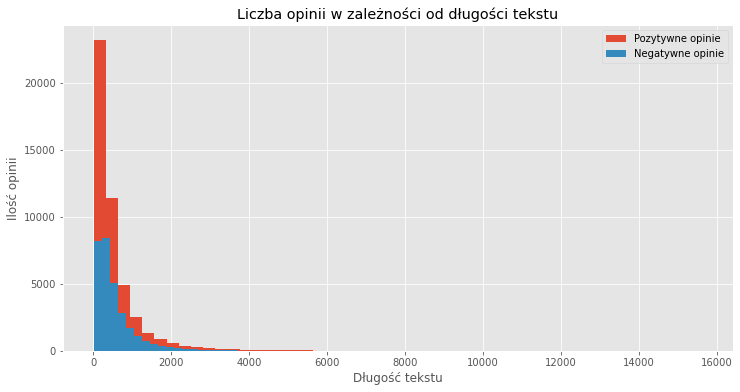

In [59]:
figure_size=(12, 6)

df['text_length'].where(df['score_bool'] == 1).plot(bins=50, kind='hist', label='Pozytywne opinie', figsize=figure_size)
df['text_length'].where(df['score_bool'] == 0).plot(bins=50, kind='hist', label='Negatywne opinie', figsize=figure_size)
set_plot_properties('Liczba opinii w zależności od długości tekstu', 'Długość tekstu', 'Ilość opinii')

Na wykresie widać, że pozytytwne opinii jest zdecydowanie więcej. Rozkładają się one podobnie. Zakres długości tekstu jest do 16000, wynika to z najdłuższej opinii, która ma 15622 znaków. Nie widać jej na wykresie, ponieważ tak długich opinii jest zbyt mało w porównaniu do tych z mniejszą ilością znaków.

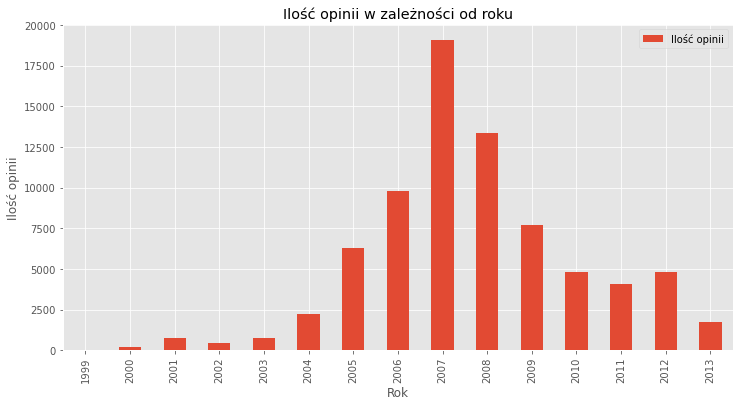

In [60]:
df['year'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od roku", 'Rok', 'Ilość opinii')

Do 2007 roku widać wykładniczy wzrost liczby opinii, co może być spowodowane zwiększeniem zapotrzebowania na telefony komórkowe oraz akcesoria. W 2008 roku widać spadek o około 6000, może to być spowodowane kryzysem gospodarczym (klienci nie kupowali telefonów komórkowych oraz akcesoriów, więc nie wystawiali opinii). Nie tłumaczy to jednak spadku ilości opinii w następnych latach. Sprzedaż komórek na rynku znacząco rosła w tych latach, a ilość opinii malała. Może to być spowodowane zmniejszeniem sie sprzedaży bezmośrednio u firmy Amazon, może być też spowodowane wzrostem niechęci do wystawiania komentarzy. Jednakże najprawdopodobniejszym wyjaśnieniem jest sposób zbierania danych. Nie udało mi się dotrzeć do informacji w jaki sposób było to przeprowadzone.

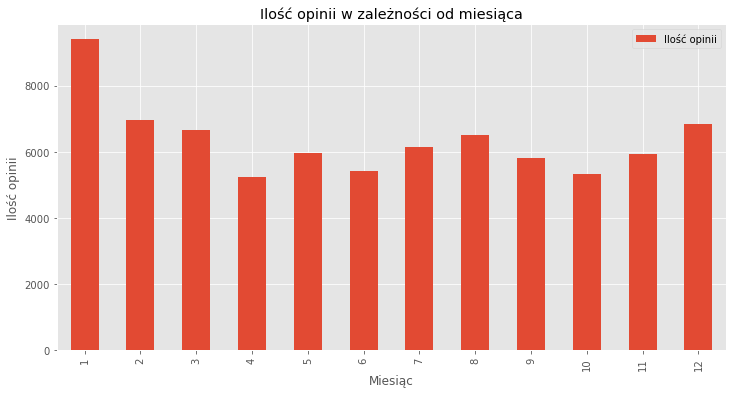

In [61]:
df['month'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od miesiąca", 'Miesiąc', 'Ilość opinii')

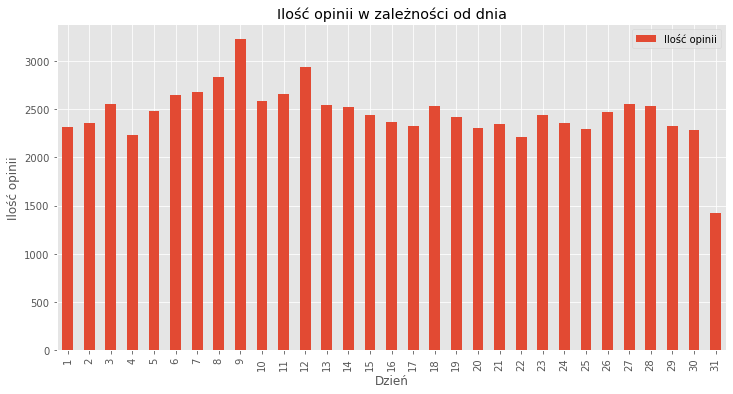

In [62]:
df['day'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od dnia", 'Dzień', 'Ilość opinii')

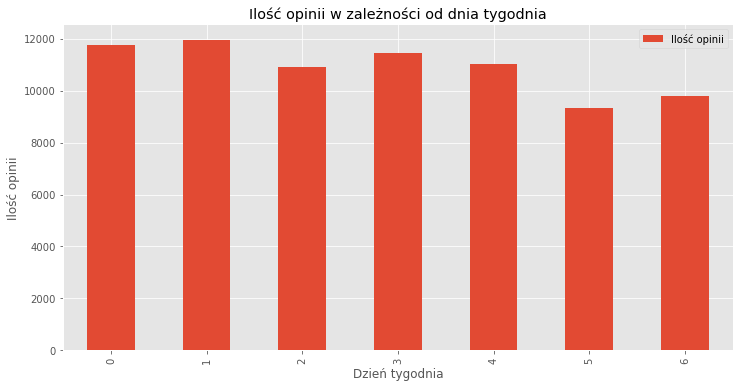

In [63]:
df['weekday'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od dnia tygodnia", 'Dzień tygodnia', 'Ilość opinii')

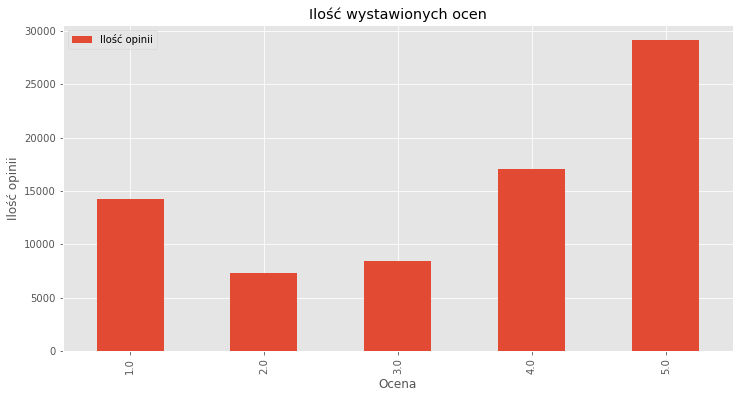

In [64]:
df['score'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość wystawionych ocen", 'Ocena', 'Ilość opinii')

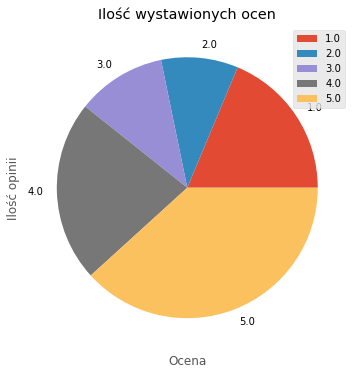

In [65]:
df['score'].value_counts().sort_index().plot(kind='pie', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość wystawionych ocen", 'Ocena', 'Ilość opinii')

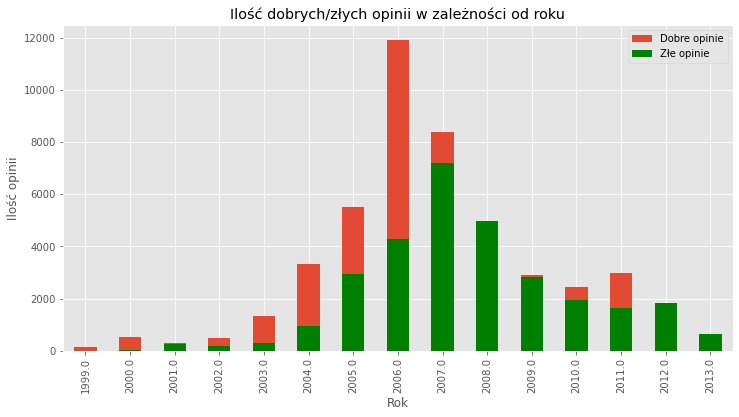

In [66]:
df['year'].where(df['score_bool'] == 1).value_counts().sort_index().plot(kind='bar', label='Dobre opinie', figsize=figure_size)
df['year'].where(df['score_bool'] == 0).value_counts().sort_index().plot(kind='bar', label='Złe opinie', 
                                                                         color='g', figsize=figure_size)
set_plot_properties("Ilość dobrych/złych opinii w zależności od roku", 'Rok', 'Ilość opinii')

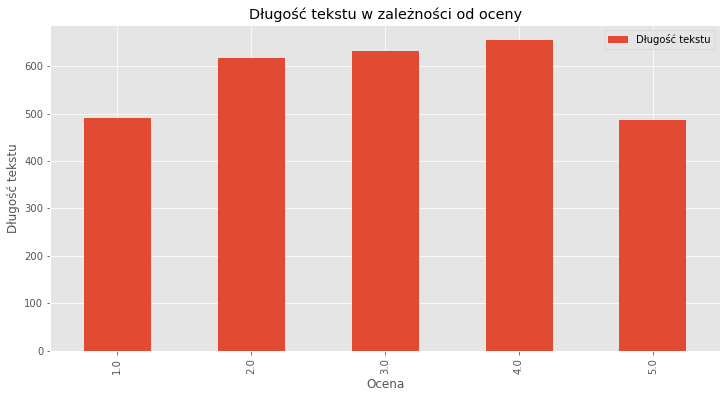

In [67]:
df.groupby('score')['text_length'].mean().plot(kind='bar', label='Długość tekstu', figsize=figure_size)
set_plot_properties("Długość tekstu w zależności od oceny", 'Ocena', 'Długość tekstu')

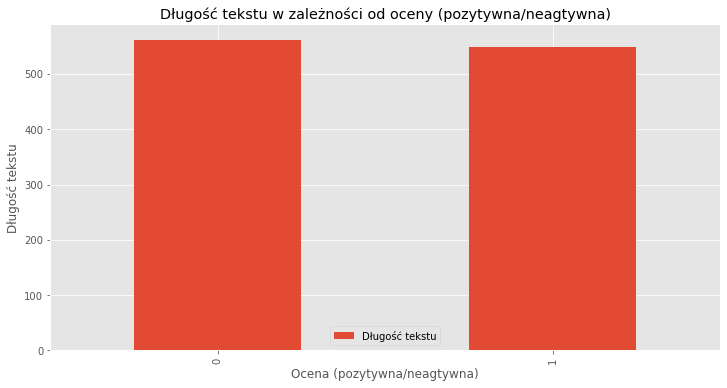

In [68]:
df.groupby('score_bool')['text_length'].mean().plot(kind='bar', label='Długość tekstu', figsize=figure_size)
set_plot_properties("Długość tekstu w zależności od oceny (pozytywna/neagtywna)", 
                    'Ocena (pozytywna/neagtywna)', 'Długość tekstu')

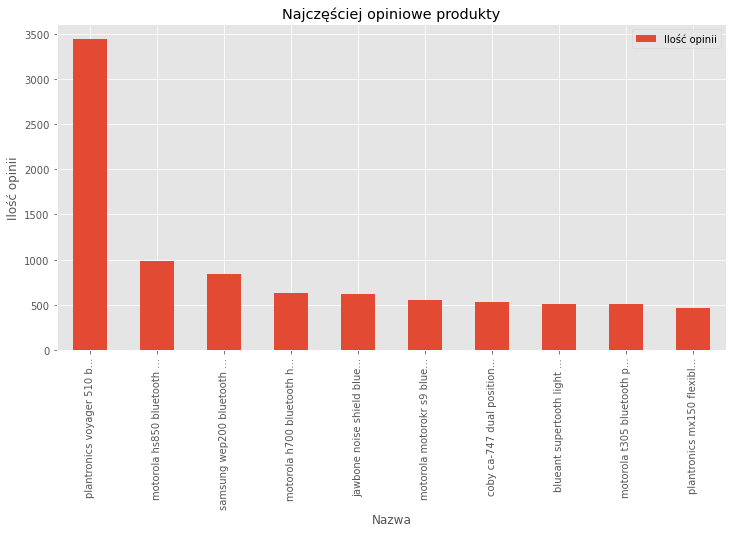

In [97]:
df['title'].value_counts()[:10].plot(kind='bar', label='Ilość opinii', figsize=figure_size)
plt.xticks([i for i in range(10)], labels=[str(xtick[:25]) + '...' for xtick in df['title'].value_counts().index[:10]])
set_plot_properties("Najczęściej opiniowe produkty", 'Nazwa', 'Ilość opinii')

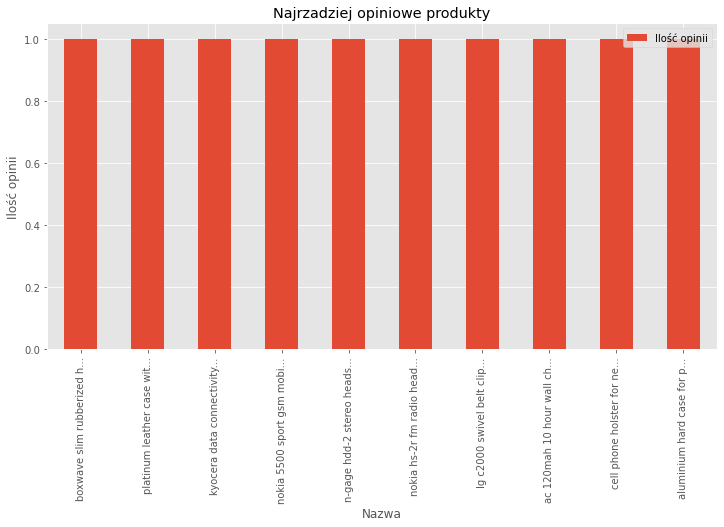

In [99]:
df['title'].value_counts()[-10:].plot(kind='bar', label='Ilość opinii', figsize=figure_size)
plt.xticks([i for i in range(10)], labels=[str(xtick[:25]) + '...' for xtick in df['title'].value_counts().index[-10:]])
set_plot_properties("Najrzadziej opiniowe produkty", 'Nazwa', 'Ilość opinii')

# Polecanie produktów innym użytkownikom
### Sposób 1
Określenie par przedmiotów, które są najczęściej komentowane przez użytkowników. Jeżeli osoba kupi przedmiot, można jej polecić przedmioty, którym użytkownicy wystawili najwięcej opinii. 

In [ ]:
# Skopiowanie danych
df_bought_together = df.copy()

# 1 użytkownik mógł wystawić wiele opinii do tego samego produktu, co będzie w tej chwili generowało niepotrzebne powtórzenia
df_bought_together = df_bought_together.drop_duplicates(subset=['title', 'user_id'])

# Utworzenie nowego DataFrame z użytkownikami, którzy wystawili przynajmniej 2 opinie
df_bought_together = df_bought_together[df_bought_together['user_id'].duplicated(keep=False)]

# Utworzenie kolumny, w której są wszystkie produkty, którym użytkownik wystawił opinię
df_bought_together['grouped_products'] = df_bought_together.groupby('user_id')['title'].transform(lambda x: ';;;'.join(x))

# Zostawienie tylko 2 potrzebnych kolumn, oraz usunięcie duplikatów, które powstały w wyniku poprzedniej operacji
df_bought_together = df_bought_together[['user_id', 'grouped_products']].drop_duplicates()

count = Counter()

# Policzenie wystąpień par przedmiotów
for row in df_bought_together['grouped_products']:
    product_list = row.split(';;;')
    count.update(Counter(combinations(product_list, 2)))

# Wypisanie najczęściej kupowanych ze sobą par przedmiotów
for key, value in count.most_common(5):
    print(f'Przedmiot 1: {key[0]}\nPrzedmiot 2: {key[1]}\nLiczba klientów, ' +
          f'którzy wystawili opinię do obu produktów :{value}\n')

Na przykład, jeżeli klient kupi motorola h700 bluetooth headset [motorola retail packaging], można jej polecić pokrowiec motorola blt-04 bluetooth headset carrying case. Opinię do tych dwóch przedmiotów wystawiło 20 użytkowników.
Ta strategia powinna podnieść sprzedaż, ale na pewno lepszym rozwiązaniem byłoby wykorzystanie tej metody na danych sprzedażowych, nie na opiniach.
Główną wadą tego sposobu jest, to, że klient musi wystawić opinię, aby na tej podstawie mogła być wyświetlona propozycja produktu. Dlatego przechodzę do sposobu 2, gdzie nie są wymagana wcześniejsze zakupy użytkownika.
### Sposób 2
Bardzo prosta, ale skuteczna metoda - proponowanie użytkownikom produktów, które mają najwięcej pozytywnych opinii.

In [ ]:
temp_df = df[df['score'] == 1]
temp_df = temp_df['title'].value_counts().head()
for title, value in temp_df.iteritems():
    print(f'Przedmiot: {title}\nilość pozytywnych opinii: {value}\n')